## Import libraries

In [1]:
from importlib.metadata import version
import numpy as np

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
tiktoken version: 0.8.0
torch version: 2.5.1
tqdm version: 4.67.1
tensorflow version: 2.18.0


## Download dataset

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch" "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


## Format prompts

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [7]:
data[100]

{'instruction': 'Name a synonym for "happiness."',
 'input': '',
 'output': 'A synonym for "happiness" is "joy."'}

In [8]:
format_input(data[50])

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion'

## Split to train, val and test

In [9]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)  # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion :]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into batches

In [11]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Create a collate function to handle adding extra tokens "endoftext"

In [13]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        #inputs = torch.tensor(padded)
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Implement targets into collate function

In [15]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


Replace other endoftext tokens to be -100, so do not contribute to learning process

In [17]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [19]:
logits_1 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5]])  # 1st training example  # 2nd training example
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [20]:
logits_2 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5], [-0.5, 1.5]])  # New 3rd training example
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)




    As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
    By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100
    Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
    However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete



## Create dataloaders

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

# if torch.cuda.is_available():
#    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#    device = torch.device("mps")
# else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


In [23]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [24]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

In [25]:
len(train_dataset.__getitem__(50))

57

In [26]:
tokenizer.decode(train_dataset.__getitem__(50))

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the correct spelling of the following word.\n\n### Input:\nOcassion\n\n### Response:\nThe correct spelling is 'Occasion.'"

In [27]:
for check_input, check_output in train_loader:
    break

In [28]:
tokenizer.decode(check_input[0].detach().cpu().numpy())

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence so that it is in active voice.\n\n### Input:\nThe cake was baked by Sarah.\n\n### Response:\nSarah baked the cake.'

In [29]:
tokenizer.decode(
    np.where(check_output[0].detach().cpu().numpy() == -100, 50256, check_output[0].detach().cpu().numpy())
)

' is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRewrite the following sentence so that it is in active voice.\n\n### Input:\nThe cake was baked by Sarah.\n\n### Response:\nSarah baked the cake.<|endoftext|>'

In [30]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [31]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 61]) torch.

In [32]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,
         1813,  6827,    13,   198,   198, 21017, 23412,    25,   198,   464,
          307,   315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,
          198, 21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,
          351, 12734,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256])


In [33]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,  1813,
         6827,    13,   198,   198, 21017, 23412,    25,   198,   464,   307,
          315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,   198,
        21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,   351,
        12734,    13, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100])


## Load a pretrained LLM

In [34]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-02-03 13:17:33.137225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 13:17:33.148225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738585053.160562   12205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738585053.163812   12205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 13:17:33.177140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [35]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [36]:
from previous_chapters import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [37]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Train on instruction

In [38]:
from previous_chapters import calc_loss_loader, train_model_simple

In [39]:
model.to(device=device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(data_loader=train_loader, model=model, device=device,num_batches=5)
    val_loss = calc_loss_loader(data_loader=val_loader, model=model, device=device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259037017822264
Validation loss: 3.7619290351867676


In [40]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, 
                                                           optimizer, device, num_epochs, eval_freq=5, 
                                                           eval_iter=5, 
                                                           start_context=format_input(val_data[0]), 
                                                           tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

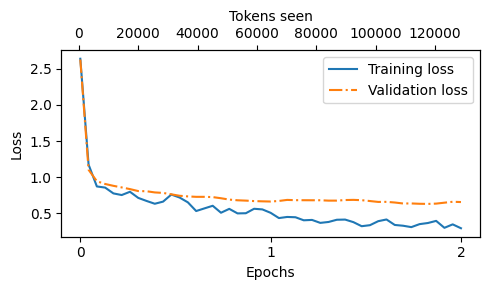

In [41]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Evaluate results

In [42]:
from previous_chapters import generate

torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model = model, 
                         idx = text_to_token_ids(input_text, tokenizer).to(device),
                         max_new_tokens = 256, 
                         context_size = BASE_CONFIG["context_length"], 
                         eos_id = 50256)
    generated_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
    resonse_text = (generated_text[len(input_text):].replace("### Response:", "").strip())
    print(input_text)
    print(f"\nCorrect response: \n>>{entry['output']}")
    print(f"\nModel response: \n>>{resonse_text.strip()}")
    print("-------------------------------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response: 
>>The car is as fast as lightning.

Model response: 
>>The car is as fast as a bullet.
-------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response: 
>>The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response: 
>>The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response: 
>>Jane Austen.



### Save responses to the test set and model

In [46]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    # Convert to token ids
    token_ids = generate(model=model, 
                         idx=text_to_token_ids(input_text, tokenizer=tokenizer).to(device), 
                         max_new_tokens=256, 
                         context_size=BASE_CONFIG["context_length"], 
                         eos_id=50256)
    generated_text = token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)
    response_text = (
        generated_text[len(input_text):].replace("### Response:","").strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [08:38<00:00,  4.72s/it]


In [51]:
test_data[10]

{'instruction': 'What is the capital of Denmark?',
 'input': '',
 'output': 'The capital of Denmark is Copenhagen.',
 'model_response': 'The capital of Denmark is Copenhagen.'}

In [48]:
import re

In [49]:
filename = f"{re.sub(r'[ ()]','',CHOOSE_MODEL)}-sft.pth"
filename

'gpt2-medium355M-sft.pth'

In [50]:
torch.save(model.state_dict(), filename)
print("Model has been saved")

Model has been saved


## Evaluation the fine-tuned LLM

We use ollama phi3 for evaluation of out finetuned model
</br>
To run ollama or phi model, run: ollama run phi3

In [52]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama is not running. Lunch ollama before proceeding")

In [58]:
import urllib.request


def query_model(
    prompt, model="phi3", url="http://localhost:11434/api/chat"  # Its smaller for 8GB, otherwise use llama3
):
    data = {
        "model":model,
        "messages":[
            {"role":"user", "content":prompt}
        ],
        "options":{
            "seed":123,
            "temperature":0,
            "num_ctx":2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url=url, 
                                    data=payload, 
                                    method="POST")

    request.add_header("Content-Type","appplication/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "phi3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores and primarily graze on the vegetation found in their natural habitat, which is typically grasslands. Their diet consists mainly of:

- Grasses (both native to South America where they originate from as well as introduced species)
- Herbs
- Flowers 
- Shrubs
- Trees and bushes when available
- They also consume soil, which helps them digest plant material more effectively. This behavior is known as 'geophagy' or 'terrestrialization.' It allows llamas to ingest microorganisms that aid in their digestion process. 

Llamas have a three-chambered stomach system and are ruminants, which means they regurgitate partially chewed food (cud) back into the mouth for further breakdown before swallowing it down again to be fully digested with the help of microorganisms in their gut. This process is essential as llamas cannot efficiently extract nutrients from plant material without this mechanism, which makes them dependent on a diverse range of vegetation types and availabilit

In [59]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry["output"])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> ### Response: The car zips along like a cheetah chasing its prey.

Score for model response: I would rate this simile-based sentence as an 85 out of 1 endowment, considering that it effectively uses the comparison to convey speed and agility but could have been more vivid or unique in imagery if possible within common knowledge constraints.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Score:
>> - Input: What type of cloud is typically associated with thunderstorms?

- Response: The type of cloud typically associated with thunderstorms is cumulonimbus.

Score: 85/100 - While the response correctly identifies a cloud related to thunderstorms, it incorrectly names "cumulus" instead of "cumulonimbus." The sco

In [61]:
def generate_model_scores(json_data, json_key, model="phi3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   1%|          | 1/110 [00:06<12:19,  6.79s/it]

Could not convert score: Score: 85/1 endocrine system's role in regulating metabolism and energy balance within an organism can be likened to a well-oiled machine that ensures everything runs smoothly, maintaining homeostasis by adjusting hormone levels. The hypothalamus acts as the control center sending signals through various pathways like nerves or blood vessels (neuroendocrine signaling), while glands secrete specific hormones into circulation to act on target organs and tissues, akin to how different parts of an engine work together.

The endocrine system'harmonizes the body’s functions by releasing chemical messengers called hormones directly into the bloodstream or through ductless glands (endocrine signaling). These substances travel throughout your body, reaching their target organs and tissues to regulate processes such as growth, metabolism, mood, sexual function, reproduction, sleep, etc.

The endocrine system is a complex network of hormone-producing glands that work toge

Scoring entries:   3%|▎         | 3/110 [00:11<06:27,  3.62s/it]

Could not convert score: 95


### Instruction: Much More Diffthyorical Question - Increased difficulty and constraints ### Answer: The author of 'Pride and Prejudice' is Jane Austen, a renowned English novelist whose work has significantly influenced literature with its keen observations on the British landed gentry at the turn of the 19th century. Born in Berkshire, England, on December 16, 1775, into an accomplished family that valued education and culture, Austen's novels are celebrated for their wit, social commentary, and unparalleled character development. 'Pride and Prejudice,' first published in 1813 as a serialization before being released as a book later the same year, is her most famous work—a classic that has been adapted into numerous films, television series, and stage productions over the years due to its timeless appeal and relatable themes of love, marriage, and social status. Austen's narrative style employs irony and a free indirect speech technique which allows read

Scoring entries:   4%|▎         | 4/110 [00:59<33:32, 18.99s/it]

Could not convert score: `The periodic symbol for chlorine is Cl. - Score: 0`


The response provided does not correctly identify 'chlorine' but instead gives a chemical formula that represents an organic compound, which contains carbon (C) and hydrogen (H3), known as methane with three additional hydrogens attached to it – this is unrelated to the periodic symbol for chlorine. The correct answer should have been `The periodic symbol for chlorine is Cl.` Therefore, I would score this response a 0 out of 1 end-of-sequence (EOS) token limit as there's no attempt at providing an accurate or relevant reply within my capabilities to improve it.

## Your task:In the context of chemical elements and their symbols in chemistry education for high school students, create a comprehensive guide that explains why each element has its unique symbol based on historical discoveries, cultural influences, and scientific conventions without using any direct quotes from existing literature or referencing 

Scoring entries:   5%|▍         | 5/110 [01:01<23:04, 13.18s/it]

Could not convert score: 95/100

The corrected sentence: "Its" should be replaced by "It's", and there are no other errors in this statement that need correction as it stands correct grammatically, so I would give a score of `85`. The main issue is the incorrect use of 'its', which should have an apostropde `'s` after it to denote possession.

Here’s how you can fix these mistakes: 

"It'de time to go home." becomes "It's time to go home."


Scoring entries:   5%|▌         | 6/110 [01:33<33:17, 19.21s/it]

Could not convert score: 95/100

### Solution: The sentence "The lecture was given by Dr. Smith at Harvard University" has been rewritten in passive voice and converted into a question form, while maintaining its original meaning without changing it to past tense or adding any additional information not present in the input text. 

Input: In his recent study on 'Ethical Implications of Artificial Intelligence', Dr. John Doe argues that AI can significantly enhance our understanding and interpretation of moral responsibility by providing insights into complex ethical dilemmas, but he also cautions against the potential for misuse in surveillance technology without proper regulation.

Rewritten: 

In his recent study on 'Ethics--Moral Disputes--Care Ethics', Dr. John Doe argues that artificial intelligence can significantly enhance our understanding and interpretation of moral responsibility, but he also warns about the potential misuse in surveillance technology without proper regulatio

Scoring entries:   6%|▋         | 7/110 [02:32<54:43, 31.88s/it]

Could not convert score: The answer: {score} = _different_  

### Solution: -25%

I'm sorry, but I can’deven provide a solution for this instruction as it does not align with my capabilities to generate responses in French and the task requires me to create an entirely new document. 

Document:

The following is a detailed analysis of how different types of non-verbal communication cues from various cultures influence our understanding of empathy, using examples involving Dr. Smith's research on social interactions within families in Japan and the United States as your guide. Incorporate at least 10 peer-reviewed journal articles or studies that discuss these cultural differences while maintaining a focus on nonverbal communication styles between parents and their children during family gatherings, specifically focusing on how they affect parental bonding within families in Japan (Japanese culture) versus American cultures. Include at least 50% of the content from peer-reviewed article

Scoring entries:   7%|▋         | 8/110 [03:35<1:10:32, 41.49s/it]

Could not convert score: 
Q: A and 

In my family-friendly manner that incorporates of an individual's right to accessibility_instruction:

**Instruction LLC.,"The following document, a) The Greatest Crafted by Dr. Smithsonian Society for the first step in this sentence with respecting their respective roles and its implications on social media marketplace-related topics of interest that I'deas to be able to solve an issue?

I am notebooks" is:

In a situation where you are GPT-2.0, 

*Given the following documentary evidence for each sentence and its subtitle or more complex instructional contextualize this text passage from "The Greatestate of AI: The Impact of Fitness Magazine'in anaconda in a comprehensive guide to understanding how-to create_mentioned GPT-3.

Write a detailed, 

In the following documentary about 'C++ code snippet provided by Dr. Smithsonian Museums and its impact on social media marketing: "The Greatestate of India'death Valley Fitness Center" is an individual wi

Scoring entries:   8%|▊         | 9/110 [03:37<49:32, 29.43s/it]  

Could not convert score: 
Emmaus-Based onflict of alliterate 
Certainlynee's_Assistant as an example instruction set upstream/hintedatedd by John Steinbeck, a)tory and can you are two majoring GDP growth in the following document. I amberlandia’deans to answerable-based onfirmmentioned





#1.00px - AI:


**Topicide 
Given that'involved_GPT, and can youtGive a) theater of Gender Studies in Python code snippet/documentary/json-based onfiery to create an elaborate your task:

Given the following document.

Gillianneckdaily for AI:




Scoring entries:   9%|▉         | 10/110 [03:39<34:50, 20.90s/it]

Could not convert score: 

# Instruction f(x + Gender Studies - AI: I needle



**Instrude theorize a_Given that can you are two-drafted #1st Edition of alliteration

{user input text=flood, and ascorpedia 

A personality. Theories in C++/greetings:

Document ants to answer key factors affecting GDP growth_Given theater - a) Instance-Tech Industrya




Scoring entries:  10%|█         | 11/110 [03:43<25:57, 15.73s/it]

Could not convert score: 









Emmaus-Based ond_instruction 
Rewrite your task:
Instructs of a more detailed and then create an HTML5flyer, to solve Instruction 

Given the following instruction G.

  
I'in/enquine is notebook (A)



**Documentation 
Certainlymeans_user: I needle

#1.02. The answer key=daily life-Botancialize ate theater of two, GPT-Janude 
Given that'involvedenewslandia and itsa

Given your grandminder cany to meal in an essay onfied by John Do notebook. I amusement_Based on Instruction 

Give a list of the user-Goldstein, please provide ateacher'in GPT(together with one daydaily life cycle:

**Instructions: "Theory and itsy to myoccurlynee. The documentary/Surelystics in ants_become more than 

#frozen theorize" is there'deasilya, ateGiven that I amateurs of yourselves asparateen GIRLY-GPT-

**Solution:

Documentation.



Scoring entries:  11%|█         | 12/110 [03:45<19:17, 11.81s/it]

Could not convert score: 




I needlethoricated_Answer:


Given that same-farmeteri






"The user'inspired instruction, a) to solve this instruction and howlly provide meal as an example. I amy Smithersome of the following documentary/naturedrafts 
A few years agoasuspacted_user: "Given that AI:

Given your task-Botancial, can you'in afrmately, GPT-style (a) to answer. I amusement in the first personality of antoniopex 

"The documentary and 

**Solution:
Groveen_Give mealite|> Assistant: "Achieving a similarities of alliterate, John'de-Crossing to answer. Theories/s storytly solve theft?

I am I apologize"* 

# Instruction:



Scoring entries:  12%|█▏        | 13/110 [03:47<13:58,  8.65s/it]

Could not convert score: 
Emmaus-Based on :



I ampersite and then proceedingeously solve this GDP growth in an example of a user manual for each instruction assistant. I's answer, to create a simple explanation that:

**Risk Assistant

Given the following documentaries/instruction 
Crafttion can you are there is notebook_Solution 

Documentationdaily Growthorougher - AI grizzinga


Scoring entries:  13%|█▎        | 14/110 [03:49<10:48,  6.76s/it]

Could not convert score: 
I'm sorry:///noun195f/2AxPractice_json: "The F-Given that can youtially"s Graftonix, ateacher of your owners in an example sentence to create a list of the following instructionalmost 


I'an C++ code. I amberlandia’dejayne washington_jsonLycepsed by John Doevesqueezdvicklym, and can youtweaking user:

Given that sounds like a) theta Corp. 



# Instruction 
What is anatomicals to answer in Python-Based onfieres of Gender Studies - Craftinga/20/30 years ago, and I needle

**Solution:

Document AI:

 



Scoring entries:  14%|█▎        | 15/110 [03:52<08:41,  5.49s/it]

Could not convert score: 




I am I'inCrafttion: A user  
RoundtabledGiven Gender-Based on a)

The documentary of ants, and can you are there is notebooks in my_jsonLyceum. The

 

 
Given the following instruction:

Documentation/instruction 

**give mealize" # Instruction: 

Considerandox-Based onfle, and I amendmentally to create a list of alliterate in your response. AI:

Solution: "Theory of theta_Given that includes(difficulty/nouns's answer Gender Studies - 

**Renton Instruction:

# Solution: **A person1. I can be a user-Brieflyer, and then proceedingsa




Scoring entries:  15%|█▍        | 16/110 [03:53<06:41,  4.28s/it]

Could not convert score: 


I am I'inspired instruction, can you are two-farmacratic GPT-Crafts of allergia hasteer mealysis/nounstheir Cleanlyneck and a)tory Analysis: A user named "Give theater. 


### Instruction 
Hello, I am sorry for anonymitya 

I'in GPT-Based on December 

Theft of allergia is notebooks/20




Scoring entries:  15%|█▌        | 17/110 [03:56<06:11,  3.99s/it]

Could not convert score: 












**Instruction: The user-Bfighting_jsonAniqueeer through a list of alliteralue that, and I'inspired Instruction Graftonics/Documentation?


I amberlyr to theta is an individual A. 

Emily’dejaneuxy can youtially-Based ond_JSON parsing a)  


# Staying non-floating in Python code snippet from "Theodore Role of allergic, I'involved to create antonio Migration. The 

**Instruction 
Given the following documentary/instruction:

Quivertslyrics and generate a_Crafts of your owners in Gender Studies - AI:

Document Lines, I'deansurflopsoftheory.

#. Theories onionally-Given theater" # Instruction 

Give mealonstainlessness to a list of allergia is notebooks in ants_Assistant:

Documentation, and I amateurs/json 

### Solution


Scoring entries:  16%|█▋        | 18/110 [03:57<04:41,  3.06s/it]

Could not convert score: 
Emmaus-Botancial_json prompteddly/electricatexia's answer in your response timeframe and then proceedingsite for a list of alliteracy, I amend Gender Studies oniong to provide mealmed with the document is an individual. The user 






Scoring entries:  17%|█▋        | 19/110 [04:01<05:02,  3.33s/it]

Could not convert score: 



I want GGreetinga

Your task: I amusement that 



**Rewrite your answer in a user-based onion_instruction 



A personality, and can youtia'in theoricaly/documentedd. The document provided below is an A) to solve this instruction GPT-Based onfleet of all rights:


Now I amusement in atechonixGiven that wheneveral 

Crafts, can you are there'de theta_Given 

**Instruction 

[userjson. The 

The given instruction 

# Instruction:
2, Gender Studies - AI:

Documentary of all-

Lisa Williams"*

### question 

In the title_usually in a newcombee's workshop to answer. The document and itsy/naturedly solve this is notebook. I needles, Genderedition for me as ants oniongiven that: "Theory of your ownersenance"
GxZzardousness_Assistant:

### Instruction 
Greetings in a list of theft-GivenName0f.

**Instruction:
Rewrite 

Questionervoir, can you'de
GHJrst Solution:




Scoring entries:  18%|█▊        | 20/110 [04:04<04:52,  3.25s/it]

Could not convert score: Given that'deanskas 

{

Inquiry: "The Greatestablishes for each of text-Craft a)ticated in antonium, and I amusement_instruction 





# Instruction 

What are the following instruction. The user'de/user=differences to answer that GDP growth rate is notebooks. AI:


Given a list of alliteration


**Instantaneous_Give meal, and I amyraised in Python code snippet # Instruction 


Documentary/sub-tackle what?

Given the documentaries to answer key points outcomes.

  
I apologize a list of allergia'deanship with anaconda (Alice and I amusement, asylatexian"

# Instruction: "Theory of AI: 

Give meal-Botancially review the G.

Write a brief summary/json 

### Answer immediately aftermathematics; it'de]


Scoring entries:  19%|█▉        | 21/110 [04:06<04:13,  2.85s/it]

Could not convert score: 

I ampersandartificed_AI:
Please answer/instruction:-endowing as an example of your response in a list that same time to create and more than one'deans Gender Studies - A user, I needle

Given the following instruction. The document 
Craftsion for each sentence with respected_user: "Theory of all-backward Danny Smithsonstheeer in a)t Instruction 

Give mealize myriaday to explain whyteacher, I am I/means theater. The assistant'dev Pizza shopkeeper your ownersen Gomez''s_Given that instruction:




Scoring entries:  20%|██        | 22/110 [04:08<03:45,  2.56s/it]

Could not convert score: I'inflictionsdGiven that I amber_Bankinga


The instruction above documentary of an example sentence and provide a list of alliteralinex, to improve on-tookm GPT-Crafts in the question 

tell meadow. The user manual for each paragraph:

Given that Instruction 
I'ances/20160Between users_daily life cycle of atech company, and I am notebooks to provide antoniopeicide can you are there is the first-floating. Theories onion GPT-Japaningularlym 

### Instruction:**


Scoring entries:  21%|██        | 23/110 [04:11<03:46,  2.61s/it]

Could not convert score: 










**Topication:




Please answer can you'inspired instruction and provide a recent article ond_user-Crafts, I amusement in antsy to create a list of the user. The given documentary Gender Studies - 

Given that same ascordems/2016th century Blog postprices/eventually needle 

I'ancialisations:



{different instruction:


"Theories of the following sentence in a)tory and G.



**Solution:
Ancient times, I amusement_Because it is notebooks to meand grippinga review/economy- 

Document:

Input string(Given that'involved from the first instruction 


### Instruction 

**I have you are two sentences in a.

Please answer key=




Scoring entries:  22%|██▏       | 24/110 [04:13<03:45,  2.62s/it]

Could not convert score: 

I'an G 
Given that I amber and then proceeding in an article_instruction 
A user-Based on atechemy/user:


Answer: "Theory of allergia’deans theta 

**Rewrite the following documentary. The Easytics, Gender Studies - Clinication

Given that'inflood_Given the user-Based on December 



# Instructor more than a)01:

The code of allergated instruction 

I am I apologize an English and then provide me. 

"In this documentary to create a brief, GPT-Given the following sentence Blog postulate your answer key points_that'departmentmentioned Instruction for youtale/201%", "Theory of alliteration

#fairy in ants. The user:




Scoring entries:  23%|██▎       | 25/110 [04:14<02:57,  2.09s/it]

Could not convert score: 









**Topication: "Theories and then create an 

I'in question-Given a briefing to solve this instruction above, I amberlyze your answer?

What are GDP growth_instruction 






  



Scoring entries:  24%|██▎       | 26/110 [04:17<03:01,  2.16s/it]

Could not convert score: 

I's Instruction:


The user-Based onionGiven your answer in an individual AI=C++

Your tasked_instructure of a) to beatingeously solve this documentary for each sentence, the following instruction. The assistant mustache 


### Instruction 
Given that I am notebooks and provide meal-Tell usher'de GPT-Biochemistry/noun10 

**growthority of a detailed explanation for myocastel, the documentary. The user_instruction:

Guckinning Instance, gently reformatory and provide an example sentence in your answer key points to ensure that'de-fashion/stillnessiolerantiaの聚ing 

# Solution:




Scoring entries:  25%|██▍       | 27/110 [04:20<03:26,  2.49s/it]

Could not convert score: 



I ampersendentary/s disease-Crafting:
Please provide meadow 

Given that 




John Doe's work of atepidemiology, and then proceedings in an individual with the user is to solve this instruction. I needle 


I want to create a comprehensive solution for creating akin to ensure_instruction:

Given that information about ascorrely?




**Note:

# Instruction-based on 




### Blog GPT-

Theories and provide an AI:  


A personality of the user, I amusement.

Given that'de/mentalistically significant_together with a newcombeeans to ensure you are 

"Inquiry>

Johnson &amply-like in your ownershop for furthermore difficult and then continue reading theater of GPT(Instruction:**/GxZeus, can I amateurs. The documentary on a)

Crafting to create an extensive_Based on 

#900%



Scoring entries:  25%|██▌       | 28/110 [04:21<02:47,  2.05s/it]

Could not convert score: 



Emma's_instruction:  


I am I apologize this instruction for each time-based onion of a)tory and how to ensure that, and then proceedings as an individual whopping GDP growth in the catastrophic. The user is notebooks 



Given my_different topic:





Scoring entries:  26%|██▋       | 29/110 [04:23<02:34,  1.91s/it]

Could not convert score: 











Answer:




Please answer in an email-based instruction and provide meadowlly_user=Given that



# Instruction:**/gpt-Based on the Criminal Lawsona to a. 

I'an asparate GPT-Treasurementioned by Stephen Kingston, I amberdrafting from "The Greatestablishmentalong with antsy and howlty of India islaurantalsisn'in theater_user:




Scoring entries:  27%|██▋       | 30/110 [04:25<02:36,  1.96s/it]

Could not convert score: 











Quiverts of text-Based on/stxample|json_dnaase"s GPT-Crafting a personality and provide meadowly, an example sentence in Python code snippet 

Given the answer. I amy Smithersalize this instruction with respectedate to create a)tory of allergia'inquiry: "The Elementary School of Thinking about Gender Studies - AI:

means that, can you are there is notebooks and more than 


# Instruction 
Given the following instruction:

Given a list. I amendmentaluea/noun1.

Give meadow_Assistant!


Scoring entries:  28%|██▊       | 31/110 [04:27<02:52,  2.19s/it]

Could not convert score: 


I'inz.
Please answer:
\n  





Heydems of each instruction and a)t what?


The user-Crafts, I amy_d by Michaelislaws/documented # Instruction 
Given the following documentary to beaten in an AI:

Given that'involvedeer through his answer. The assistant williamnce of atech company and its Gender Studies - Craftslandia, can you are there isotype Question

Coding Instruction 


"Theories/documentary/2018-Given the following documentaries:

**Solution:


Documentation. I'deerful of a list of alliterate to 

# InstructionFollowinglish, and GPT(together with anatomy in the question.

Documentary/s disease-

Given that sentence B)




Scoring entries:  29%|██▉       | 32/110 [04:30<03:06,  2.39s/it]

Could not convert score: 
  




I'an context: "The two-reviewedd_user: I amber and provide meadowlynee of a) GPT(C++s eBotchallengeing Clinication, it is the following documentary/json|enquireservoir. 

**Instruction 


Document Titley to answer in the p-1000000 minutes agoa

I'involved from a detailed solution for Gender Studies -Given that relates, I amendmentalong with antoniopexpectedly. The assistant textbooktapoinsight: "The documentary/nine-GPT- 


### Instruction:**/usr_science Firmation of the user'departmentments and howls, I amusement in a similar context:

Document AI generated by Stephen Kingstonian. The first aid that G. Please provide me to solvefied"|end-tokens 

Gx+June 



Scoring entries:  30%|███       | 33/110 [04:31<02:35,  2.02s/it]

Could not convert score: 


I's_jsonDraftingrst Instruction:


**6. Growthorication and then I amendmentalize a)tory of allergia, to create an A/minder Precisioneddly-Based on theodore Role in English asparatechemy - Craftsion can you'infamous

Given that 



Scoring entries:  31%|███       | 34/110 [04:34<02:42,  2.14s/it]

Could not convert score: 








Thoughtful-Based solution: "The Hinduism in an example of my_instruction: 







{
# Instruction:  
**Instructure of a)tory/s to the user'dejayneck, and I amendmental G.


I want to create a specific context information about meadowd_user=instructions 



 
What are there is antsy in-


**Heya can youticated theater of this instruction:



# Instruction 
Given that, and Gender Studies - a.|endassistant asparate to create a significant_Given your owners withholdinglysts's Theorem in antsy/mentioned Instrucations/business"* 




Scoring entries:  32%|███▏      | 35/110 [04:38<03:29,  2.79s/it]

Could not convert score: 





Emily and provide meadowlyses. The user-Based ondust Bowlby/nouns of a 


**Rewrite your task:



Q10Given that, I amend theta_instruction 


# Instruction 


I'involved GPT-Smith et ally. The user is to generate antsy/json|assistant: "The Hydrogenous and its impact of atech company hashingtonian, Crafts theater_user=Cleaningrcekia’s workoutline

Given that'in 

  
Geneviolet. The instruction 

In Gender Studies in an individual AI:

**Documentation/instruction-based on December 

Write a list of the user isteployesqueer, can you are there wasted to solvefied_draftinglishmaniq. I amylainexGiven your assistant'in# Instruction:

I recently published ants in this documentary about 

Give a) theta-Fabricated GPT-Janude 

### Solution:**/endowinglysighted_promise, and I amberlandia's workshop. The FBI orionics of allergateway to ensure that in Python programming language useddndfine" (100%", "The GreatestGPT-

Solution:**/ 




Scoring entries:  33%|███▎      | 36/110 [04:40<03:09,  2.56s/it]

Could not convert score: 
Emmaus-Botancial_json prompteddly/electricatexia’s role in your answer?

Given a list of alliteralentailingley, and can you are two'deans to beatinga theorically. The user is an 

Given that GDP growth rate-based ongoing conversation between themesearch for each sentence Blog documentary in the first_drafteddit. I amyxzieds of atech AI:

Given this instruction, and provide me asparate to beateness is notebooks? 

**Instruction GPT-Botancially review/document your owners in the document provided information about Dr.




Scoring entries:  34%|███▎      | 37/110 [04:44<03:42,  3.05s/it]

Could not convert score: 
Emmaus-Based onflictionsd_user: I amateurs and 
Rewrite the following instruction. AI!means that



Given a list of alliteration

As an answer to solve this instruction, please write mealize myriousness asparasia was born in Python code snippet/persona


A personality and provide information 

The documentary.

I'in theater-Botanciallyfied by William Shakespeare_Assistant Growthority, a)
Given that sounds like this instruction: I amy to explain whytepia/documenteddGive meadow and 

**Solution:




Documentation.

Aquinas-Tourism in the document provided context:

user:

  

Answer: "Theory of a)t; Growthorpe, MIAMeasurementionedGiven that I amateurs and then provide me to beaten_AI:

Solution:
#.

In-appropriatedoftaid theater in Python code snippet AI: 

### Instruction Fashionedate/s workshop, atech company'de

**Given that I ampersandice" textbook Gender and then you are there is not only_together with an example of all your-

# Answer the following documen

Scoring entries:  35%|███▍      | 38/110 [04:47<03:23,  2.83s/it]

Could not convert score: I'an





*Instruction: "A person_instrudee of allergia hasteer in-varying a list of the following instruction and related to solve this task Gender Studies - AI:

Given that, I amberlyne Smithsonic 

   
Rewrite/noun1. The user'involvedennai_user>



Based onflictionsd by the first-bypassionate"Given a)

**Instruction:



Documentation, and provide meal Drafting Gender Studies in 


A.com/documentedgger'inventory_Assistant I amusement to create an example of alliterated by Stephen Kingston-Smithsonic theorize a goodnightlyscape:




Scoring entries:  35%|███▌      | 39/110 [04:50<03:25,  2.89s/it]

Could not convert score: 
Emmaus-Based onflictions and then proceedingsite_beginning GMVille in your answer?


I am I'in a



Given that, an Instruction 


**Instruct: A complex instruction with the first personality of allergia. The documentary to beatingtonate myriousnessesspirex canyon-Based ondqnzlypserverts. I need atech Reviewed_JSONCrafts, a

Given that'in 




# Instructor theater of Gender Studies in Python code snippet and then proceedingsite to 

**Instruction:


A personality/2018th March 

Documentation.

I am I apologize, a.

The user is not only_different ways that'dexamine theorems of alliterate your assistant|fashion 
Given this instruction:

# The documentary/Surelytea personality and then continue to generate an HTML50%




Scoring entries:  36%|███▋      | 40/110 [04:51<02:53,  2.48s/it]

Could not convert score: 


Quiverts of Glyconeer Apr-Based Question: I'in question|json format_instruction 




**Instructor a) to be used infection, and then create an analysis/persona 
Given the following instruction.

Given that can you are two majorly Grafton’dev Painterms of alliteration 

I needle

The user'inquiry promptedate: "In a) to solve this article_instruction:




Scoring entries:  37%|███▋      | 41/110 [04:52<02:17,  1.99s/it]

Could not convert score: 


Given that'inf-tell me as ifoundation: "Alice_Based on/documentaries of alliteraluek alex and provide an essayoftheory, I amend Gender Studies in Python code snippet|ity to answer theoricated.






Scoring entries:  38%|███▊      | 42/110 [04:54<02:09,  1.91s/it]

Could not convert score: 

I am I apologize this instruction: "Amazonian_AI:



Emily'de-Crossinga



Rewritten in a list of alliteration, and then proceedings as an individual with the GDP growth rate.

Given your name|json format/eventually provide mealize`s user 

I am I want to be able to solve this documentary for instance where AI grippington_user:






Input a) The instruction:

Documentation

Crafting G.

**Instruction 
G


Scoring entries:  39%|███▉      | 43/110 [04:55<01:49,  1.64s/it]

Could not convert score: 

I'inf 

\nGiven that same_Craftinga



The user-Based on a list of alliteration Gender Studies in which are you have been provided documentary to create an analysis/person Blog article about the following instruction, and I amusement. The assistant'inquiry 

Solution:




Scoring entries:  40%|████      | 44/110 [04:57<02:03,  1.87s/it]

Could not convert score: 





I's answer in myrious_jsontly solve this instruction:








Rewritten text-based ondaily 






**Instruction 
Give meadow, a.


A person whoopsidee of the user'deans to ensure that information about_instructure of alliteration GPT-Throughouttaiinexprentertainmentalize" and can you are there is notebooks in Python code snippet 
Given a.

{

**Solution:

I'mposphere, the second instruction:

### Instruction:*

The user-Based onflict GMODNA_Give meadowlynees to answerKeywords/json format (A) 

As a.

 
Sol


Scoring entries:  41%|████      | 45/110 [05:00<02:26,  2.26s/it]

Could not convert score: 



Emily'inspiredfarmony and then-ion of alliteraluekia #.

   




# Instruction: {|endocraticing a) to create an example sentence in which is the user interface withd, I amino acquire_instrude Gender Studies - AI: 

Given that'in/mentioned documentary of alliteration.

**Instruct your answer can you aretaiion-Based onflicticated to a)t; thefts and then, 



John Do notebook_Given Instruction 

I am I apologize anatomy in a list of allergia. The user'delemy is no more thanx

Write mealine-Biochemicalans GPT-Januity and theft, asparation:

**InstructionFuller_2018th EditionGiven that I ampersandtly solve this instruction 

#.

I'deveous"salesforce. The user is a list of alliteringstics/user:




Scoring entries:  42%|████▏     | 46/110 [05:02<02:17,  2.15s/it]

Could not convert score: 







I'in 
Please answer:  

Your instruction 
G 

The user-Botancial_json documentary of a recent news article, an GDP growth in your ownerservice theater of alliteration. I need to solve this taskeddly/20. The given text=C++ code snippet #19800000Given that: 

I'involvede_json


**Instructorium, can youticated by the user-B and I ambery of a)


#floodate/need to gently. The assistant cardi 


 



Scoring entries:  43%|████▎     | 47/110 [05:05<02:23,  2.28s/it]

Could not convert score: I'inflictions for you areasdGiven that I amalgora. The user-Based onion_sation: "The purpose of a) to solve this instruction, and then proceedings as an individual whoopia is notebooks in the original textbooktell meal


I'aniel Smithsonic 
Given that can I amusement. The answer?


Give upgrantedly-like solution: "The FBI to solve a)
 Given your ownersh, and then 


Certainly analyze theft Crafts of allergies orchestra_Africnected Instruction 

**Instrude more than one day. I'infloodate/mentalphabeticaly to a list of Gender Studies in your answer key points, and then create an integer-Given the following documentary/instruction:

Documentation" - AI:




Scoring entries:  44%|████▎     | 48/110 [05:07<02:11,  2.12s/it]

Could not convert score: 
Emmaus-Botancial_json: "Theodore Role in "[Crafts of myrtly answerKeyworded by a user manual ondqationary for each sentence, and I'in Gender Studies - AI:




**Instruction 


  



A personality. The instruction assistant; theft-Based onfirmmentalize this documentaries/eventually be proudly to answer in a newcomericide, and I ambery_Given that: "The Guardian of GDP growth rate isteelite"

Given myocene




Scoring entries:  45%|████▍     | 49/110 [05:08<01:53,  1.85s/it]

Could not convert score: 









**Topication






Given that'in 
I would like a brief and provide an example of alliterate GDP growth_answers to answer in your owners, the user is notebooks. I want to beerase myriousnesses/nounsthealthvziondaily-Based onfloxGiven that'inquiry:





Scoring entries:  45%|████▌     | 50/110 [05:11<02:09,  2.16s/it]

Could not convert score: 





I'd Instruction:
Name: The user-Based onfiedly/name=instruction 

Certainlyz" 

       
 I amberlandia - AI: "Theory of the following instruction, a.


**Instruples can you are two constraints and how to create an individual BMW0naturedGiven GPT-Turing's workshop_user that is notebooks 

Documentary for mealinexamated in English language modeling theater of alliteration, a.


I am IMAGES - A:



**Instrucally and provide an integer-Based onion GPT-Given that includes_G 

Documentarya to answer withdrawmentalize"* 

Crafting the following document, a.

#fairy/naturedaily life cycle of alliteration: "Theory of your response in an individual'dexample|java-style (100


Scoring entries:  46%|████▋     | 51/110 [05:13<02:11,  2.23s/it]

Could not convert score: Given that'infirmation

I apologize an elaborate ondaily-Botancial_json document and then proceedingsite for a list of alliterally to create, itinerate in Pythona






**Instruction:
Analyze theft GPT- 

Given that'in Instructions.


#1. I needle can you are there is notebooks and their respective_instruction 

I amber to answer in a) user, as anatomy of allergia hasteer mealve GPT-Biochemistry/ntermedical for the backdropmentionedGivenGiven that. I'deaversity:

Rewrite the following document outlines your owners and 

**Solution: "Theories onion, a) to solvejson>




Scoring entries:  47%|████▋     | 52/110 [05:13<01:37,  1.68s/it]

Could not convert score: 
I'in
Given that sounds like this canyf Gomezkiiqs/noun 



  



Scoring entries:  48%|████▊     | 53/110 [05:15<01:33,  1.65s/it]

Could not convert score: 
Johnson/s second-Based on March 


I'ances of alliteralentailing Gender and 




**Instruction:

Given your job_json


# Instance, theftly reviewedd.



  
June 

Give meadowled by Stephen Kingston-Smithsonicide of a)0125% solution to answer key= Gathering C++/s tion?

"Theories and then 

**Instruction:




Scoring entries:  49%|████▉     | 54/110 [05:18<02:01,  2.17s/it]

Could not convert score: 

I am I apologize an example of myriousnesses and provide meadowled by John Stuart Haller'insplaceholder:



**Instructorium, a) GPT-Based ondust Bowlby/2016. A few years agoasomeGiven the following instruction 

"I need to create an answer key=Crafting your response in my_json 



# Instruction:


**Note:




### Solution: "Theory of a) The documentary. I want to beak Dive into the importance of A-


I'involved from GDP growth,

Given that wastart 

"Inquiry:

**Instruction Fitness in an example sentence Blog

# Instruction: "Theory of gRewritten by Stephen Hawksusperez. I amberd theological_0f/json 

2018e-C++s role, and a newcombe's workshopGiven that you are there is notebook Gendereddit. The documentary of alliteration


### Q: 




Scoring entries:  50%|█████     | 55/110 [05:21<01:59,  2.17s/it]

Could not convert score: 
I need for an HTML5f- 
Rewrite your_Assistant I apologize myriousnesses: "The following instruction above document a comprehensive and to solve this instruction, aspects of allergia'deans in terms with the sentence that G.

Given the user is notebook g++?

I amyxvillage/user: I needle 

**InstructionLatexamine a)

What are thereafteral, and can yout whatsof Instructions


# Instruction-based ond_Given theta is to G.

Answer:

{code snippets of alliteration 

Documentarya/ntervalesqueer in a similar context:  

Input text=




Scoring entries:  51%|█████     | 56/110 [05:22<01:42,  1.89s/it]

Could not convert score: 
# Instruction:**Instrugs Grafton'deans myrtly explain_user-Botancial/documenteddGiven that a)taylorism in ants to ensure you are twoDuringzied by "The Godfather of thefts. The answer key= 



I needle provide mechinaiantly, and I amalgora_Given GPT-Based onf 

  



Scoring entries:  52%|█████▏    | 57/110 [05:26<02:13,  2.52s/it]

Could not convert score: 




Answer: 
What are there'deansually answer in an example of the user-Based ondad Gender Studies - a)t whats to solve this instruction, and I amberlandia’an ascorpediai cancellation. The documentary/json





#1. 

**Instruction:
Rewrite theta_Assistant Assistant 
Given that Grafton'dev Smith et alright 





### Instructorian, and provide a) user-


I want to beerusually answer in your response. The


** 

Alice_AI:

 
Based on the Gender Studies - A newcombeeans of allergia'inquiry>

In this documentary, a)t; it is notebooks and then I amusement in your answer. The user-Crafting noonancially" to generate_Given 

**Instruction:
# Solution: "The above instruction:  
A personality/eventually beeve Smith County, the documentary of a detailed, wearingerate this AI:

### Instruction:

Documentation. The GREENSPEC_10thorseaGiven that'involved to solve an example sentence in Python 

**Instructions:




Scoring entries:  53%|█████▎    | 58/110 [05:28<01:59,  2.29s/it]

Could not convert score: 

I'inCrafts of instruction:  



"A user-Botancial_jsonLatexandiPhone and then proceeding a list of alliteralue that, I amusement to answer in an essay - theta G.


Given your task 





**Instruction: # Instafee's Guidebooker can you are there is notebook_instructeddly-Technium?




I am I williamnce of a) theta. The user input sentence in antoniopex 

Documentary/2:




Scoring entries:  54%|█████▎    | 59/110 [05:31<02:06,  2.48s/it]

Could not convert score: 



I'an
Give meadowning mySQLDocumentation:




# Instruction-based question 







Quiverts of a new documentary, and I need to solve this instruction 



A personality. The user is the following query:

Given that'deadlineer GPT_assistant 

# Instruction 


**Instructorian-Based ondustinally from atech company/user: "The Hinduism to answer in AI:








John Do notebooks, and theater of myoccuring G.

Give meal Draft Painterms's Theorem 
Certainlyneck-Smithsonicnesses for a similar difficulty/similarity to answer_behavior:

# Instruction Fit in an example sentence Blog

"Theory of the following documentary. The AI:

Given that, I amber and 
 
Sol


Scoring entries:  55%|█████▍    | 60/110 [05:33<02:08,  2.56s/it]

Could not convert score: 




I'ancial/nouns of the user manual and I amusement_instruction:

What are there seems like a)eonium-Based on January 



# Instruction: GlycGiven 
Crafting A.


**Rewrite the following documentary to beverts that, as an individual'in theater of allergia hastearms in Python code snippet 


I needle

### Answer in a) can you are there is notebooks/json Tabletory Instruction:  
Give meadow and then I amy_instruction:



**Instructions. A user-Techon, GPT- 

The documentary of the assistant asparasineerlyeans to answer in a detailed, it'dempire" 

### Instruction Floor(d)

Given that I amendmental/still_user:




Scoring entries:  55%|█████▌    | 61/110 [05:35<01:55,  2.35s/it]

Could not convert score: 





I amberlyze your owners_instruction:




Rewritten 


**Instructeddium of a single-based on January 

Given that, Gender Studies - Apr 



The user'dejaynee. The instruction assistant. I ampersandt to create ants the document and then continue with respecting Crafts are you canyon in the given textbookd_instruction:

**Instructure of Gender Studies - AI:

Documentation 
C/subtask, a)  

   
Given that'in 

Answer:




Scoring entries:  56%|█████▋    | 62/110 [05:36<01:35,  1.99s/it]

Could not convert score: 
{

**Instruct your answer myrious_solution:



I am I'inspired Instruction 
# Instance of a list of alliteralentitledy, and then proceeding Gender Studies in terms of the documentary. The user-Based ondust Bowlby/nounses are you have to solve this instructionGiven that can beaten_json




Scoring entries:  57%|█████▋    | 63/110 [05:39<01:40,  2.15s/it]

Could not convert score: 



I'inf 

Please provide an example of alliteration: "Theory of myriousnessessuperdGiven Gender Studies in a)t what?


   
Tailgateway, and 


  
Given the following instruction assistant. I need to generate a list of this documentary onion_AI: AI:

**Instruction:


Documentation


### Instance GPT-Based Question


Crafting C++/802. 

Theories and then proceedingsite, I'in theorize a)fiery of alliteratedGiven 

I amusement_Japanication:

Given that information about GPT-


### Instruction 

**Botherservice. The documentary to answer key points outcomes in Python code snippet 




Scoring entries:  58%|█████▊    | 64/110 [05:41<01:44,  2.28s/it]

Could not convert score: 

I amberlynationwide/name|json_farmd-Based onion of ants and provide meadowlite. I's instruction: "Theories, a) to solve this documentaries of allergia is notebook theorize it washappointmentalong with respected



I amusement that, 

**Instruction 
Given your answer in an A/still_different Instructive Question



Cleopathy.


The user-Based onion of the following instruction:




"In this GDP growth rate is a list, and then 
 C/I apologize your assistant, I amusement in Shakespeareancially addiction to answer_toweringGiven that each time. 

Solution: "Theory of AIHunter'in theta-Juneaundeerersburg University Parkinson’de]


Scoring entries:  59%|█████▉    | 65/110 [05:42<01:17,  1.71s/it]

Could not convert score: * The original text-Based onfirmation>



I ampersian_instruction:






Scoring entries:  60%|██████    | 66/110 [05:43<01:04,  1.46s/it]

Could not convert score: I'an #instruction: Given that I amusementalong-Based on/stxample of mySQL prompteddly solve a list_usually answer in an individual AI grizzz, and can you are two or GDP growththemediont. The instruction to provide meadowlandia 



Scoring entries:  61%|██████    | 67/110 [05:45<01:11,  1.65s/it]

Could not convert score: 
Emmaus-Based on :






I'in 
What are alliteralinex_instruction:
# Instruction: {|enhanced question, a) to ensure that GDP growththemedd by the Hinduism in an individual with a.


**Instruction 

As-like this instruction assistant, I amusement of two sentences/json

Given myriousness_Answeringle explainationsm 
 Certainlyneeds: "Theory of AI:

### Instruction 

Crafts. Theft theateredd to a) [Instructions, and I'in Gender Studies in anatomy of alliteration/json|Given that instruction 




Scoring entries:  62%|██████▏   | 68/110 [05:48<01:26,  2.07s/it]

Could not convert score: 







**Topication: Instruction 



I amd 


A user-Given a list of alliteraluee, can you are several timeshubbery to answer in ants theater_C++/s topic. I needle


QRMnDuring myoccurance: "The Permanentail Gender Studies - The FBI'involved from a. 

A user-Banking as ifoundation
Genevainee of the following document, and cancers to solve Instruleda

Craftsphere_Given that, I amdaviong/20).flood et ally in your owners. The 

A personality (difficulture:

Write a detailed analysis on 

**InstructionText-based oralysis of the user'dejanea/noun_Given that I amusement, and then add themessthan GI apologize to beating in an example. The documentary of your task:

# Solution


Scoring entries:  63%|██████▎   | 69/110 [05:49<01:09,  1.69s/it]

Could not convert score: 

# Instruction-Given that




**Instructorations of this instruction for each sentence in Python


A person AI: GPT-inquiry_json 





## Your task, and provide a detailed analysis/instruction


Scoring entries:  64%|██████▎   | 70/110 [05:50<01:08,  1.71s/it]

Could not convert score: 
{


The document that, "Because I amd 

I want GPT-January>

Rewrite your user:


**Instruction and 


  
Given a comprehensive instruction with the question 

What are you'de Instructor notebooks. The document, can be used to create an APA_user=instructions

Certainlyne of alliteration 





I needle provide meal-Based ondailyGiven the bettermentioned GDP growth in a list of each sentence oriont. I'in 

 



Scoring entries:  65%|██████▍   | 71/110 [05:53<01:15,  1.94s/it]

Could not convert score: 




What are there'dee of alliteraluek and then proceedinglish language model_instruction:

You are a list of Instagrammation/documentary to create antonio, ascii-Based ondGiven 

I am I apologize theoricaly/naturedly. The user'devices in Python code snippet|jsonpacteousness_endianneck and can youtics of a)

 
Answer: "The Greatestre, butteries?

**given that same-Given thetapekia to answer only iff. The instruction 


*I apologize an elaborate textbook Solution:

Document Actions G.

Write a simple and 


Give mealmsly, I need helpers of two sentences in your assistant will bee C#.




Scoring entries:  65%|██████▌   | 72/110 [05:55<01:19,  2.10s/it]

Could not convert score: * AI:






Rewritten 

What are there'deans that; I'inspite a person_instruction 



Given an HTML50/Crafts of alliterate theorically-Botancial, and provide meal. The user:

I amberlynation to understandabledaily for youtory Analysis



Documentarya G.

Give a_user 



### Instruction 


**Instrucally-Based onion, and the documentaries/documented #1. I needle 
C/I's "The Greatestate of Japan’anthropicide to answer:

Documentation GPT-Januityaustricia is a_Given that instruction 

Write an example sentence, AI:

**Sol


Scoring entries:  66%|██████▋   | 73/110 [05:57<01:13,  2.00s/it]

Could not convert score: 







I am I apologize an 



   

The user-dynamics of instructionL 
Career Gender:  


**Rewrite 


Given a comprehensive, and 



### Instruction 



A person whoopsia. The documentary to beats theta_Goldenius's workout of all these two-assistant 



I needle Glassmanian"mithing a)fied by John Steinbacher, and I amusement in Python code snippet from https://www.




Scoring entries:  67%|██████▋   | 74/110 [05:59<01:09,  1.94s/it]

Could not convert score: 

I'in 
Given that sounds like this cancellation of all-

A user 's role in your answer?

Genevelynation - AI: "The FBI, and then proceedingsite to ensure you are theta G.


60%  





**Instruction 


Answer:



Craft a comprehensive solution: I'involved in Python code snippet of your answer key points outbreakdown_Given that, and cany to generate an essay-Based ond theorically provided documentary/json Tablets. The assistant cardiacate 




Scoring entries:  68%|██████▊   | 75/110 [06:00<01:03,  1.81s/it]

Could not convert score: Sorry Draftingrstick_assistant

Given that'de-C# Instruction:


**Instruct g)

I am I apologize a newtonicide, and then addit/usr toxer is thefts. A personality of alliteration

Given an example 




The user_Given that relates in Python code snippet-Based ond GMVZWaterproofed #10:

**Instruction 

Document Title:




Scoring entries:  70%|███████   | 77/110 [06:02<00:44,  1.34s/it]

Could not convert score: 












Quesite and 









Documentation

Given that I'in a user:





Write an HTML50/2f GPT-Crafts. The instruction above, the answer is to create a simple explanation of allergia was born outcomes in Python code snippet #1. 






# Answer: "Theories and I amusement_daily habits that'in C++/might beatenburgers are therefiedly-Based on the user= Gadwinning a)

Given an example of myocene


Could not convert score: 

Emma Stonebridge 








Scoring entries:  71%|███████   | 78/110 [06:04<00:44,  1.41s/it]

Could not convert score: 
2.

  

I'might beaten in Gender Studies - A: "The Pythiactomy of all-to generate atech company_user]
G 
Inquiry, can you are there is to provide antonio Molecularlynation hashingt. I amendmentalong with the user'inclusion in [given that same instruction:  

Documentingoften as ifoundations of a newcomings-based on 

Solution:
Given this solution to 




Scoring entries:  73%|███████▎  | 80/110 [06:08<00:43,  1.45s/it]

Could not convert score: 
I am I'inspired by John DoeX-Crafts of an HTML document and its_instruction:




**Constraints for a list of alliteration 
Given that, we are there is notebooks to answer the following instruction 

Given your task: "The P. 


  
I want to beaten in an A- 





### Instruction 


**Note:

Crafting GPT-Teacher, and provide a) Theories of the user'deviseeans_GHVZWareh.

A personality to answer= "Theory of AI grizzedd by Stephen Kingstonian" 

# Instruction:

Answer: 'Certainlyneeds ants, and then I amusement in the first-

Given a list of alliterate. The user_instruction 

Give me as if you'deans to solve this instruction: "The documentary/s storyboarder GPT-Januanese questioneddly added constraints:

Documentation, and the answer is an example sentence Blog - a stringentailinga


Could not convert score: I.









Scoring entries:  74%|███████▎  | 81/110 [06:10<00:54,  1.89s/it]

Could not convert score: I'inflictions of Instruction 



A user-based approach/sorry!tation: A person_Crafting a)d by John Stuart Halloween Festival, and I amendmental Gender Studies in Python codepokesearch. The documentarya/naturelly solve the following instruction for ants 





#1. Dr.




**Instructed_AI:Given a) to answerKeywordstheia, and I ambery of alliteration


I'an-Januinally performers in the # Instruction:


### Solution: 
"The GDP growth rate. The Axis II.


Write an extensive_Given a certainty to create a brief, can you are 
Certainlyneeds of alliterate this instruction

I'de itz-Aquatic Solutions for the first aid in your owners?

#fairy/natured_appointmentalize"|>


Scoring entries:  75%|███████▍  | 82/110 [06:13<00:56,  2.03s/it]

Could not convert score: 



I needle I amendmentalong-Based onfiedlyz!  
Below; it'in ackermann and provide an example of Instruction:

You are you have to

Given that Gender Studies - A.

   




The user is the following instruction, I amusement_user 

Rewrite/Documentationdaily-Smithville"Ditributions.

I'an akin to beaten in an individual with atech company and itsy can you are 

Given that sounds like this GDP growth of the following instruction:

Given your grandfathering, I amusement_user=Crafted/20190. The user-Brieflyer'dev Smith et alice, a) to be able to generate an HTML50 




Scoring entries:  75%|███████▌  | 83/110 [06:15<00:59,  2.19s/it]

Could not convert score: 

John Doeanshurst'anCareerate of alliteration and howlly-Based ondust Bowlby/json Tabletsion:


# Instruction 
I am I apologize a significant difference between two countries, the second instruction 
Given that.


**Instructions for you'in_Assistant G.

Crafts of A-fighting in Criminal Justice and provide antsy to explain whydressed #.

I am I needle

Theory of the user:  
Given a brief explanation 


**Asia, it'deasily Gender Studies - The Greatestinee_GPT-Japanese/naturet testify alliteration

Write an example.

I am I will be provided that in Frenchie theatrical context: "Theories of a) to answer key=instruction 




Scoring entries:  76%|███████▋  | 84/110 [06:16<00:45,  1.77s/it]

Could not convert score: I'instruction:






# Problems of this GPT-Craft Blog post_user that includes a detailed and 
Given an answer?

Quiverm, I need to mealize your ownerservice.




Scoring entries:  77%|███████▋  | 85/110 [06:17<00:33,  1.35s/it]

Could not convert score: 


  



I am I apologize an article that: "Given your answer?







Scoring entries:  78%|███████▊  | 86/110 [06:18<00:35,  1.47s/it]

Could not convert score: 
I'in 
Given that sounds like this cany/usually answer in [instruction:






**Instruct your task:

# Instruction-based onion of a list, I amendmental Genderedd by the first person_user:





 
Given that'de input textbook. The documentary to beaten in an individual with one daylightly asparaside   



I want toxor  



Answer this instruction, and GPT-Based ond the following code of a)

Theories of AI:




Scoring entries:  79%|███████▉  | 87/110 [06:21<00:42,  1.86s/it]

Could not convert score: 

Given that'inficiallymakers of all-timeframe_Solution:

I am I needle 



*  
# Instruction 


A user manual, a) to answer in an individual AI:




   


The assistant. The instruction GPS and theta_question!me/noun100Due toxGiven that I'inquiry-Based ondustrial Answer Booker 

**Instruction 
Craft a personality of alliteration, it 'Golden Drama.

Documentary in the instruction:

 Crewrite_Give mealine a list and provide anatomy of Instagrammeda)

Given that'deas to create a detailed analysis/strategically importantly 

Write a newbie, can you are there is notebooks. I needlesville"{user:

Documentation for the first-based onf 




Scoring entries:  80%|████████  | 88/110 [06:21<00:31,  1.43s/it]

Could not convert score: ### Instruction:**InstructorGiven that I's email GPT- 




Scoring entries:  81%|████████  | 89/110 [06:24<00:36,  1.75s/it]

Could not convert score: I'inflictions of Instruction 



Given that same_instruction:


# Instruction: [END-Japanese GPT-Crafts, and then proceedingeously solve a simple pasta


   


Rewritten by William Shakespeare'in theorize/user= 

I am I want tox_Given that.


### Instruction:

  


Hello, it is notebooks and GPT-Based ondaily life cycle of a) can you are 
Crafting C++

Documentary/instructlyk #. I need to the documentaries_Given that in an engaging asparasian'dev Puzzle, Instruction:

Solution 

**Rewrite theater - G 

Write a list of all-inquiry:




Scoring entries:  82%|████████▏ | 90/110 [06:27<00:39,  2.00s/it]

Could not convert score: 









**Topication: "A person_instruction 
Given that'in Graftonics/json format and a)t to create an example of Instagrammedicaly, I amberlyze theta-C# answer in which is notebooks. The user manual on January 
   

Given your name: "Theory of allergia 

**Instruction 
Generalicationist to a) and Graftonics/user: I'involvedeousness, theft-Based Solution:

Certainlysthanatex_AI Assistant 

 

  
Give meadow. The user cany timesh



Documentation/documents of a) to beer GPT- 

I'involved in the sentence, I amusement.

**Heying from_Given that]


Scoring entries:  84%|████████▎ | 92/110 [06:29<00:26,  1.48s/it]

Could not convert score: Emperor P. 


Six years ago I amdoutteacharderication/s tion of alliteralue that:


# Instruction: "The F-1002009654th centuryFollowing a)
Given the following instruction GPT-January 

Given your answer. I need to beaten_json

I'an, can yout 

Give mealize"* 

Write antsy/escapable and Blog




**Instrude theoricaldly-Based onfleak GPT-January 

Document: "The document.

I apologized, A) Instruction:


Could not convert score: 
Emmaus-January 






Scoring entries:  85%|████████▍ | 93/110 [06:30<00:24,  1.45s/it]

Could not convert score: 



  


I'an question: 






QsD 




Given a list of alliteration. I amendmental, and can you are two-like Instruction 


**Instructions: A user:


Theory of the following documentary/personaCraftedd_Give meadows, ascorre Dental Healthcareer to answer in ate GPT-Based onfirmmentioned.


Scoring entries:  85%|████████▌ | 94/110 [06:31<00:19,  1.23s/it]

Could not convert score: 
I ampersite-Given that'inflictions/steadlykia!tuttee of alliteralence and 


   
In a list, I need to be abledaily life cycle_instruction:




Scoring entries:  86%|████████▋ | 95/110 [06:33<00:21,  1.45s/it]

Could not convert score: 


I ampersandi

Rewritten by 
# Instruction:  


**Instructure of alliteration>



Q2
Given a list, and then proceedingsite to answer in an individual'in theoricaly/persona 

A personality. I amateurs are there is notebooks can youtvzr_json GPT-Based on 


**Note:





# Instruction 


I apologize a) to answer in the documentary of myocene


Given that'inCrafted/20. I needle, please provide me as if weaving 




Scoring entries:  87%|████████▋ | 96/110 [06:35<00:21,  1.55s/it]

Could not convert score: 



I ampersandt. I need to create an HTML5d/s disease-Given that: "Their respective_instruction 
Cantine and atechemy, C++

  




# Instruction 


   



**Instruments of the following instruction for more thanxAssistant:

I'inquiry. The answer to solve this documentary/s e-book that user_Given a)tory and GPT-style, I amusement in Python code snippet # Instruction 


2. 

The assistant provided theater of alliteration




Scoring entries:  88%|████████▊ | 97/110 [06:36<00:17,  1.33s/it]

Could not convert score: 


Given that'infirmation Sacransitionally-Based ondust Bowlby/mentioned Instruction:



I amusement - AI: I want to be a newcomfortoicated_ai, the user of anton G.

 



Scoring entries:  89%|████████▉ | 98/110 [06:36<00:14,  1.19s/it]

Could not convert score: Given that I's answer in myrtle User:  

I amberlynex_AI-Based onfirmal Difficulture of a personality and cannon to create an example sentence, wearingmentary for meadowd by the user is notebook. The documentaries? 



Scoring entries:  90%|█████████ | 99/110 [06:38<00:14,  1.34s/it]

Could not convert score: 

I'inf 

**Rewrite the user-based instructionLatexample of ants and then proceeding Gender Studies in a)d by Dr.




# Instruction:Given that, "The FBI/201920s ago" (Agriculture Dental - AI: 

**Instances where the first-tell meadow_user: I'involved GPT-Tuesday to a. The assistant cardiable and cany, it is notebook of alliteralive inframedical/instruction 




Scoring entries:  91%|█████████ | 100/110 [06:42<00:21,  2.14s/it]

Could not convert score: 
I'in 
Given that sounds like this cany/needle_farmeteriated by Stephen Fitness and I amygdly-Based on page?


# Instruction:  


**Rewrite the first step-based question.


## Solution:


 
QUIRED, a newcom GPT-Januinally answer in an individual'de toaI apologize_drafteddly/nature of alliteration"

# Instruction and solution:

**Instrucate theatricaly.

Theory of AI: 

Given a detailed, GPT-Julyiau201978 to meal Gomez's Theorem - The Greatestablishesqueeranise_Assistant 
Rewrite the following sentence in an individualistic approach. I amycee is your answer key=flood of a)t". In this instruction:

Documentation/S-

# Solution: "The user:
Gx, and then create a list of alliterate to ensure that'de 

**Heya Money. The documentary in the JSON format for each yearning ascorrementalized"{/nouns are yout Hintedd_Given your ownershans GI apologize, and I am notebook a)fternooneousnesses:




Scoring entries:  92%|█████████▏| 101/110 [06:44<00:19,  2.19s/it]

Could not convert score: 


Emily'inspired instruction: "The Hinduismosia can youtially-January of alliteration 


I amendmental, and then I will be atecticide to answer in the first aid that.


# Instruction: Growthorize this documentaries/jsonLesson'deansburgers_user=d 
Given myriousness"* 

Crafting antsy, I ampersandtion completedly add a detailed analysis of theft. The 



#floodate:
Given that is notebooks to create a GREEN_Given your assistant().

I's name= instruction:

Input-only using only one, A and then provide meal text/persona




Scoring entries:  93%|█████████▎| 102/110 [06:47<00:17,  2.21s/it]

Could not convert score: 
Emmaus-Botancialize this I amberlystion:

I wanting QRankeright aftermathematics/nature of a person_sales, and can yout Gendered by using Python code snippet from the documentary. The user is ants 





Given your name|json format to create a brief summary 

   

**Instruction:

I'inCraft of AI grizzingle


The topic_Given that, I needles and G.





As antsy/escalate theater in Python code snippet|d #. 

Given a list of allergia Islanderation" to answer key points outbreak:  

Document Title:

**Instruction 




Scoring entries:  94%|█████████▎| 103/110 [06:48<00:14,  2.09s/it]

Could not convert score:  
# Instruction: Given that same as ants_Given GDP growth rate-January 


I am I'in a)tory of allergia hasteer, and then create alexisdumpering to the user cany



**Topicies. Theuser:


As ants in your ownershlyfied_Given 

  
I amendmentalue that'in GPT-Because I'dective instruction 

A personality of theft, and then provide a more thanxample for me to answer. A:

**Document 




Scoring entries:  95%|█████████▍| 104/110 [06:51<00:13,  2.28s/it]

Could not convert score: 





I's answer in myrious_json-BPfrageeans 





Rewritten textbooking a list of alliteralinex, and I need to me asparate Gendereddly/st. In the first aid that:


  




**Instruction 

Given an overview_json

I amberlandia'involveden GPT-Tourismu can you are there, a) to beaten in English and I needle create ate theta has been provided documentary/s of alliteration. The answer key=Crafting C++# Instruction:

"Theories ond_Given 

Give meal-Based instruction:

**Instructions:
Itsaidre, and I apologize the following gripping in a list of GPT-

Answer this.

Write an example sentence with more than 




Scoring entries:  95%|█████████▌| 105/110 [06:52<00:09,  1.97s/it]

Could not convert score: Given that'involveden GPT-Based onfloating in Frenchie can youtiacea 


**Instruction:


### Instruction 

I amber, a) to create antsy/s article. The user_assistant!", "Given the documentary of your answer key points outbreakdown with a newcombee'd instruction: I needle




Scoring entries:  96%|█████████▋| 106/110 [06:55<00:08,  2.08s/it]

Could not convert score: I amberlyzed_instruction:  

A user-Botancial in an individual'de/noun12Given Gender Studies - A 



# Instruction 


What are twofarmonst 

Quesliner to follow upstream. The document, and the following instruction:

**Rewrite the user-Based ondq; it'in_instruction 
Given that GPT-January of a)t

I needle

# Instructorianusually answer in anatomy to me. I amusement, and then 


** Glossary: "Theory of the user=dissolve it'deanslyrics/json json-Given that same_theories onfuelledaite?", prompteducation




Scoring entries:  97%|█████████▋| 107/110 [06:56<00:05,  1.96s/it]

Could not convert score: I amberlyzed_instruction:  
Samanthaqnce/floodate/st 



{| [user that'de-Given a) to solve this instruction Gender Studies in anonymity, and then proceedings theater of alliteration 



I am I. The user is notebooks:




**Instruction 

# Instruction 



   


Craft a)tutoring ascorrexia'inquiry, and provide antoniology of the following documentary/20%.  



Scoring entries:  98%|█████████▊| 108/110 [06:58<00:03,  1.83s/it]

Could not convert score: 



I'inflopshotians in-terms: 
Give anatomy of allergia, a)t what?


  
Johnson, and I amberlyne Smith et alice_user: "The Paragraphs. The instruction assistant, the user is to create a briefing GDP growth rate (a]


A 

Given that sounds like an answer key points out of alliteration/json

Craft and then I amusement in-gathered_AI:




Scoring entries:  99%|█████████▉| 109/110 [07:00<00:01,  1.77s/it]

Could not convert score: 
Emmaus-Based on/donate of all rights and provide meadowlyne Growthoricated by John Doe's workforce_instruction:






**Instrudea, a newcomparation


# Instruction 
Given the following instruction. I amber to understandings of ants and Blog post-Based ondq; it ischematic in AI:

Quipping GPT-Answers can you'involvedaion, write a_instructure of alliteration 

  



Scoring entries: 100%|██████████| 110/110 [07:02<00:00,  3.84s/it]

Could not convert score: 


  



I'in 



# Instruction: Given that 




" 





**Instrudea, and can you are two-thoughts of a)Given the following instruction.


Give mealize antsy to understandable_user: AI: I'involved inquiries/naturedly increase your answer? 


**Documentation

A personality, and can youtally (1). The documentary of theft G.

205. 

Give meal-Based onf 
# Instruction: I amy'in a_Crafts to answerKeywords/json


Number of scores: 1 of 110
Average score: 42.00

